<a href="https://colab.research.google.com/github/ella00100/Titanic/blob/main/Titanic_ensembleModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Top 4% with ensemble modeling

## 1. Introduction

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data


### 2.1 Load data

In [263]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c titanic
!ls
!unzip titanic.zip

Saving kaggle.json to kaggle (3).json
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
 gender_submission.csv	'kaggle (3).json'   test.csv
'kaggle (1).json'	 kaggle.json	    titanic.zip
'kaggle (2).json'	 sample_data	    train.csv
Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gender_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [264]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [265]:
def detect_outliers(df,n,features): 
  """
  이상치 탐지 함수
  df : dataframe
  n : 동시에 이상치로 탐지되어 제거할 변수의 수 
  features: 이상치를 탐지할 변수 리스트
  """
  outlier_indices = [] #이상치 데이터포인트의 인덱스
  
  #이상치를 각 변수별로 탐지
  for col in features:
    Q1 = np.percentile(df[col],25)  
    Q3 = np.percentile(df[col],75)  
    IQR = Q3-Q1  

    outlier_step = 1.5*IQR  #이상치 경계값

    #이상치로 판단되는 데이터 포인트의 인덱스를 리스트로 저장
    outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3 + outlier_step)].index
    outlier_indices.extend(outlier_list_col)

  #이상치 인덱스 리스트에서 각 데이터포인트가 탐지된 빈도 계산  
  outlier_indices = Counter(outlier_indices)

  #동시에 n개 이상의 변수에서 이상치로 탐지된 인덱스를 리스트로 저장
  multiple_outliers=list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

#동시에 2개 이상의 변수에서 이상치로 탐지된 인덱스 리스트를 Outliers_to_drop 변수에 저장
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

- 이상치는 예측에 큰 영향을 미칠 수 있기 때문에(특히 회귀 문제의 경우) 이상치를 관리하기로 결정했습니다.

- Tukey 방법(Tukey JW., 1977)을 사용하여 이상치를 감지했습니다. 이 방법은 분포 값의 1분위수와 3분위수 사이에 위치한 사분위 범위(IQR)를 정의합니다. 이상치는 (IQR +- 이상치 단계)의 범위를 벗어나는 행입니다.

- 숫자형 값 특성(Age, SibSp, Sarch 및 Fare)에서 이상치를 감지하도록 결정했습니다. 그런 다음, 최소한 두 개의 이상치 숫자 값을 가진 행을 이상치로 간주했습니다.

In [266]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상치를 감지했습니다. 

28, 89, 342번 승객은 높은 티켓 요금을 가지고 있으며, 나머지 7명은 매우 높은 SibSP 값을 가지고 있습니다.

In [267]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### 2.3 joining train and test set
categorical conversion (See feature engineering)과정에서 동일한 특성 수를 얻기 위해 훈련 데이터셋과 테스트 데이터셋을 병합합니다.

In [268]:
train_len = len(train)
#train과 test를 수직병합(axis=0), 기존 인덱스는 버리고 새로운 인덱스 생성
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.5 check for null and missing values

In [269]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- 나이(Age)와 객실(Cabin) 특성은 많은 결측값을 가지고 있습니다.

- 생존(Survived) 결측값은 결합된 테스트 데이터셋에 해당합니다(Survived 열은 테스트 세트에 없고, 훈련 세트와 병합할 때 NaN 값으로 대체되었습니다).

In [270]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [271]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [272]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [273]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3.Feature analysis

### 3.1 Numerical values

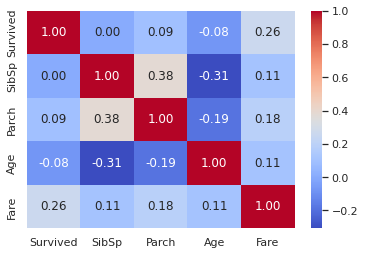

In [274]:
#numerical 변수 간 상관관계 
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = '.2f', cmap='coolwarm')

- 생존 확률과 유의미한 상관 관계를 가진 특성은 운임(Fare) 특성뿐입니다.

- 하지만 이는 다른 특성들이 유용하지 않다는 것을 의미하지는 않습니다. 이러한 특성들의 하위 모집단(subpopulation)이 생존과 관련이 있을 수 있습니다. 이를 확인하기 위해서는 이러한 특성들을 자세히 탐색해야 합니다.





### 3.1.1 SipSp

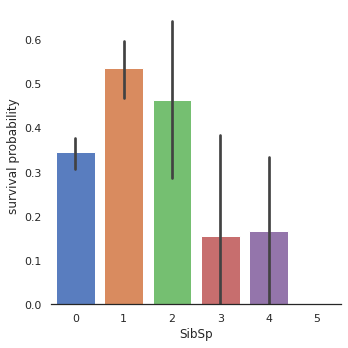

In [275]:
#SipSp

g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 형제/배우자 수가 많은 승객들은 생존 확률이 더 낮은 것으로 보입니다. 

- 반면, 형제/배우자 수가 없는 승객이나 두 명이하의 형제/배우자를 가진 승객들은 생존 확률이 더 높은 것으로 보입니다.


### 3.1.2 Parch

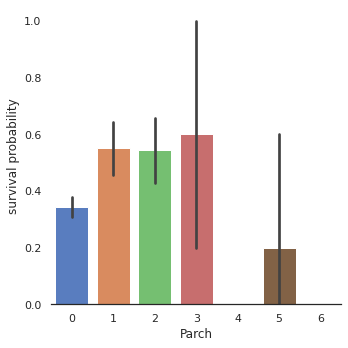

In [276]:
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', palette = 'muted')
g.despine(left=True)
g= g.set_ylabels('survival probability')

- 소규모 가족(Parch 1,2)은 혼자, 중간 규모(Parch 3,4) 및 대규모(Parch 5,6) 가족보다 생존 확률이 더 높습니다.

- 다만, 3명의 부모/자녀를 가진 승객의 경우 생존율에 중요한 표준 편차가 있으므로 주의해야 합니다.

### 3.1.3 Age

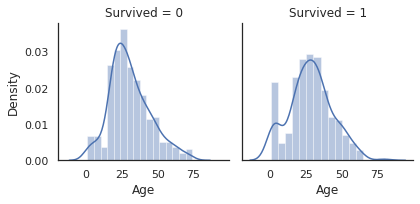

In [277]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

- 나이 분포는 꼬리가 있는 분포로, 가우시안 분포일 가능성이 높습니다.

- 생존자와 비생존자의 나이 분포가 서로 다르다는 것을 알 수 있습니다. 실제로, 생존한 젊은 승객들에 해당하는 피크가 존재합니다. 또한, 60-80세 사이의 승객들은 생존율이 더 낮은 것으로 나타납니다.

- 따라서 "Age"가 "Survived"와 상관관계가 없더라도, 생존할 가능성이 높거나 낮은 연령대의 승객이 존재한다는 것을 알 수 있습니다.

- 매우 어린 승객들은 생존할 가능성이 더 높아 보입니다.

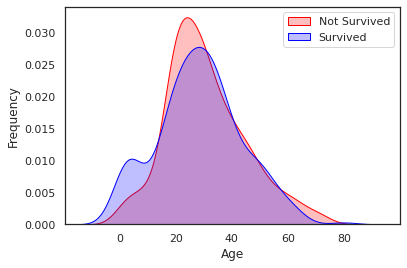

In [278]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train["Age"].notnull())],color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

plt.show()

- 우리가 두 밀도를 중첩할 때, 우리는 매우 어린 아이들에게 (0과 5 사이의) 피크 대응을 볼 수 있다.

### 3.1.4 Fare


In [279]:
dataset['Fare'].isnull().sum()

1

In [280]:
#Fare의 NA값을 중간값으로 대체체
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

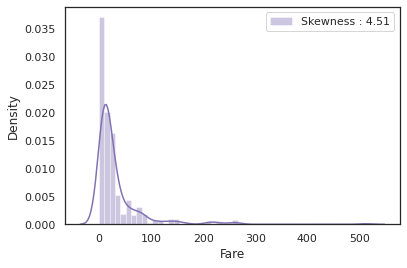

In [281]:
g=sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

- 우리가 볼 수 있듯이, 요금 분포는 매우 치우쳐져 있습니다. 이는 모델에서 매우 높은 값에 가중치가 과도하게 부여될 수 있기 때문에 스케일링을 하더라도 문제가 될 수 있습니다.

- 이 경우, 로그 함수를 사용하여 변환하는 것이 이 치우침을 줄이는 데 더 좋습니다.

In [282]:
#i>0 인 경우에만 로그값 반환, 그렇지 않으면 0반환환
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

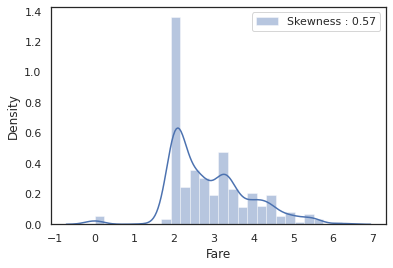

In [283]:
g = sns.distplot(dataset['Fare'], color='b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

- 로그변환 후 왜도가 확실히 감소했습니다. 

3.2 Categorical values

### 3.2.1 Sex

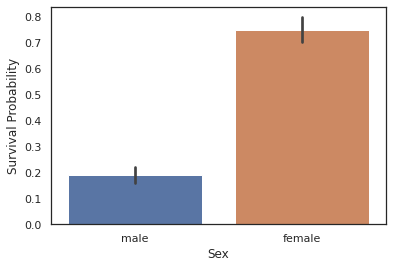

In [284]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [285]:
train[['Sex', 'Survived']].groupby('Sex').mean()


,Survived
Sex,
female,0.747573
male,0.190559


- 남성보다 여성이 생존 확률이 높다는 것은 분명히 눈에 띕니다.

- 따라서 성별은 생존 예측에 중요한 역할을 할 수 있습니다.

- 영화 '타이타닉' (1997)을 본 사람들은 모두 기억할 것입니다. 대피 중에 나온 "여성과 어린이 우선" 이라는 문구가 바로 그것입니다.

### 3.2.2 Pclass

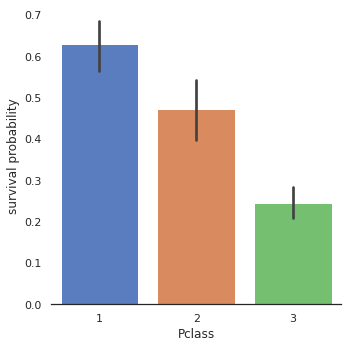

In [286]:
g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', palette = 'muted')
g.despine(left=True)
g=g.set_ylabels('survival probability')

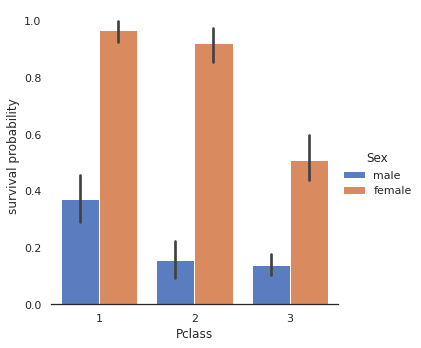

In [287]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', palette='muted')
g.despine(left=True)
g=g.set_ylabels('survival probability')

- 승객의 생존 확률은 3등석 승객에 비해 1등석 승객이 더 높습니다. 또한, 남성과 여성 모두에서 이러한 경향이 유지됩니다.

- 즉, 1등석 승객들은 2등석과 3등석 승객들에 비해 생존 확률이 높습니다. 이러한 경향은 성별에 관계 없이 나타납니다.

### 3.2.3 Embarked

In [288]:
dataset['Embarked'].isnull().sum()

2

In [289]:
#na값은 S로 채움움
dataset['Embarked'] = dataset['Embarked'].fillna('S')

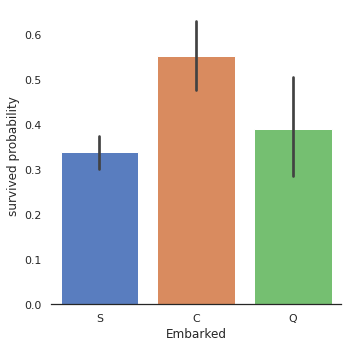

In [290]:
g= sns.catplot(x='Embarked', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survived probability')

- 셰르부르(C)에서 온 승객들이 생존 확률이 높은 것으로 보입니다.

- 저의 가설은, 셰르부르에서 온 승객들 중 1등석 승객의 비율이 퀸스타운(Q)이나 사우스햄튼(S)에서 온 승객들에 비해 높기 때문일 것입니다.

- 따라서 Pclass 분포와 Embarked 간의 관계를 살펴보겠습니다.

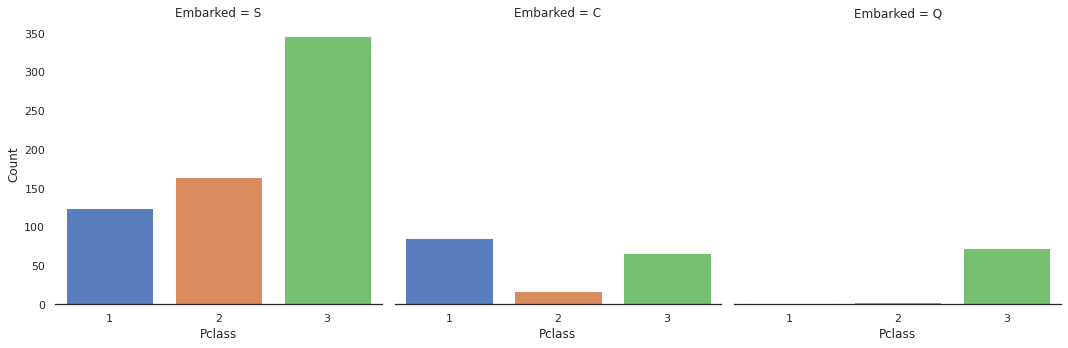

In [291]:
g = sns.catplot(x='Pclass', col='Embarked', data=train, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

- 실제로, 사우스햄튼(S)과 퀸스타운(Q)에서 온 승객들 중 3등석 승객이 가장 많은 반면, 셰르부르(C)에서 온 승객들은 대부분 1등석 승객입니다. 이러한 1등석 승객들은 생존 확률이 가장 높습니다.

- 이 시점에서, 왜 1등석 승객들이 높은 생존 확률을 가지는지 설명할 수 없습니다. 저의 가설은, 그들의 영향력 때문에 대피 중에 1등석 승객들이 우선적으로 대우받았을 것이라는 것입니다.

## 4. Filling missing Values

### 4.1 Age

- 데이터셋 전체에서 나이 열에는 256개의 결측값이 있습니다.

- 어린이와 같은 일부 하위 모집단은 생존 확률이 더 높기 때문에 나이 특성을 유지하고 결측값을 보완하는 것이 좋습니다.

- 이 문제를 해결하기 위해, 나이와 가장 상관 관계가 있는 특성(Sex, Parch, Pclass, SibSP)을 살펴보았습니다.

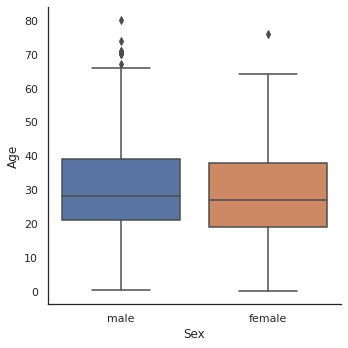

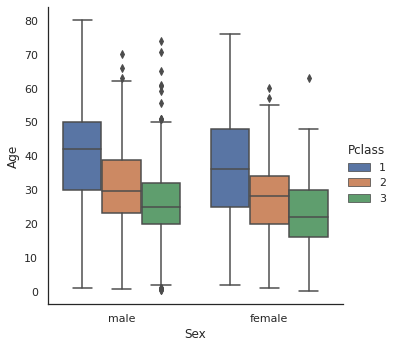

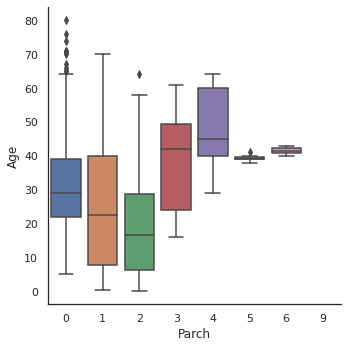

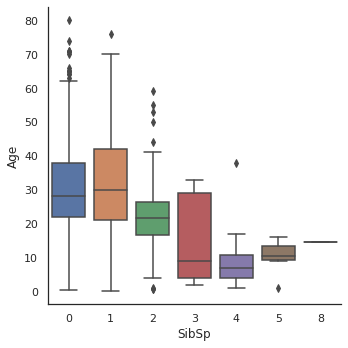

In [292]:
g = sns.catplot(y="Age", x='Sex', data=dataset, kind='box')
g = sns.catplot(y="Age", x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y="Age", x='Parch', data=dataset, kind='box')
g = sns.catplot(y="Age", x='SibSp', data=dataset, kind='box')


- 성별에 따른 나이 분포는 동일해 보이므로, 성별은 나이를 예측하는 데 정보를 제공하지 않습니다.

- 하지만, 1등석 승객은 2등석 승객보다, 2등석 승객은 3등석 승객보다 나이가 많습니다.

- 또한, 부모/자녀가 많을수록 승객의 나이가 많고, 형제자매/배우자가 많을수록 승객의 나이가 어립니다.

In [293]:
#categori 데이터를 수치데이터로 변환환
dataset['Sex']=dataset['Sex'].map({'male':0, 'female':1})

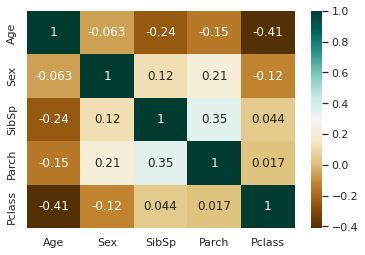

In [294]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch','Pclass']].corr(), cmap="BrBG", annot=True)

- 상관 관계 지도는 Parch를 제외한 factorplots 관찰 결과를 확인합니다. 나이는 성별과 상관 관계가 없지만, Pclass, Parch 및 SibSp와는 부정적으로 상관 관계가 있습니다.

- Parch에 따른 나이 그래프에서 부모/자녀 수가 많을수록 나이가 많아지는 것을 볼 수 있습니다. 그러나 일반적인 상관 관계는 부정적입니다.

- 그래서, 결측값을 보완하기 위해 SibSP, Parch 및 Pclass를 사용하기로 결정했습니다.

- 전략은 Pclass, Parch 및 SibSp에 따라 유사한 행의 중간 연령으로 나이를 채우는 것입니다.

In [295]:
#Age의 결측값을 보안

#Age열에서 결측값의 인덱스 추출
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

#행을 돌면서 해당 행의 SipSp, Parch, Pclass와 동일한 값을 가진 행들의 중간 연령 값으로 결측값을 대체
for i in index_NaN_age:
  age_med = dataset['Age'].median() #Age의 전체 중간값 할당
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (
      dataset['Parch']==dataset.iloc[i]['Parch']) &(
          dataset['Pclass']==dataset.iloc[i]['Pclass']))].median() #나머지 행들이 같은 값들의 중간값 할당
  if not np.isnan(age_pred) : #age_pred가 결측값이 아닌 경우 같은 특성의 행들의 중간값을 저장하고
    dataset['Age'].iloc[i] = age_pred
  else: #결측값인 경우 전체 Age의 중간값 할당
    dataset['Age'].iloc[i] = age_med


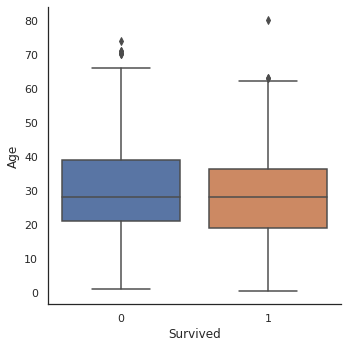

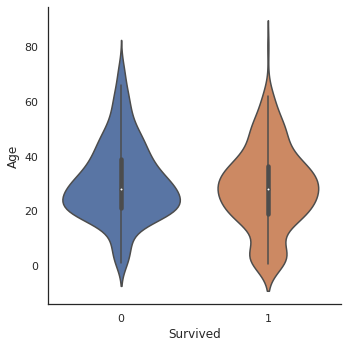

In [296]:
g = sns.catplot(x='Survived', y= 'Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

- 생존자와 비생존자의 중간 연령 값에는 차이가 없습니다.

- 하지만 생존자들의 바이올린 플롯에서는 매우 어린 승객들이 생존율이 더 높다는 것을 여전히 관찰할 수 있습니다.

## 5. Feature engineering

### 5.1 Name/Title

In [297]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- 이름(Title) 특성에는 승객의 호칭 정보가 포함되어 있습니다.

- 일부 호칭을 가진 승객들이 대피 과정에서 우선적으로 대우받을 수 있으므로, 이를 모델에 추가하는 것이 흥미로울 것입니다.

In [298]:
#(,)을기준으로 split 한 뒤 두번째 단어 선택, (.)으로 다시 분리, 공백제거(strip)
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
#Title Feature 추가
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

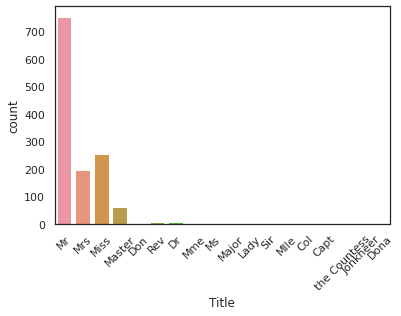

In [299]:
g=sns.countplot(x='Title', data=dataset)
g=plt.setp(g.get_xticklabels(), rotation=45)

- 데이터셋에는 총 17개의 호칭이 있으며, 그 중 대부분이 드물게 나타나며 4개의 범주로 그룹화할 수 있습니다.

In [300]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":int(0), "Miss":int(1), "Ms" : int(1) , "Mme":int(1), "Mlle":int(1), "Mrs":int(1), "Mr":int(2), "Rare":int(3)})

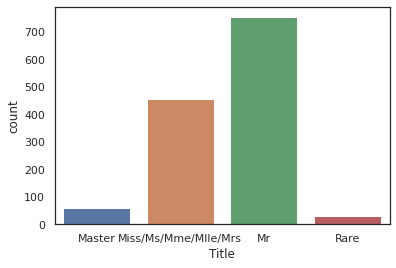

In [301]:
g = sns.countplot(x='Title', data=dataset)
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

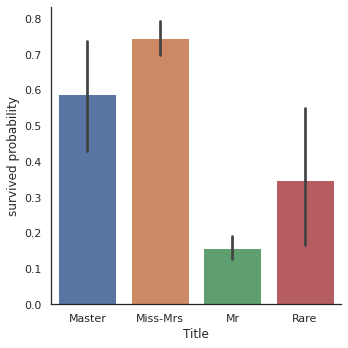

In [302]:
g = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', "Rare"])
g = g.set_ylabels('survived probability')

- "여성과 아이 우선"

- 흥미로운 점은, rare title을 가진 승객들이 더 생존할 가능성이 높다는 것입니다.

In [303]:
#Name 열 삭제, inplace=True : 원본 데이터프레임에서 열을 삭제
dataset.drop(labels = ['Name'], axis=1, inplace = True)

### 5.2 Family size

우리는 대가족이 대피하는 동안 자매/형제/부모를 찾는 데 더 많은 어려움을 겪을 것으로 상상할 수 있습니다. 따라서 SibSp, Parch 및 1 (승객 포함)의 합인 "Fize" (가족 규모) 기능을 만들기로 결정했습니다.

In [304]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

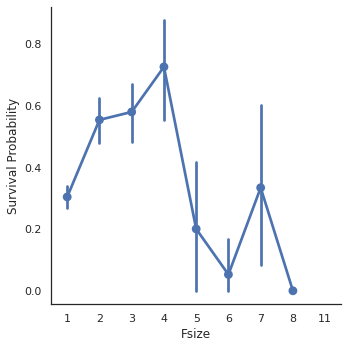

In [305]:
g = sns.catplot(x='Fsize', y='Survived', data=dataset, kind = 'point')
g = g.set_ylabels('Survival Probability')

- 가족 규모는 중요한 역할을 하는 것으로 보이며, 대가족일수록 생존 확률이 낮아집니다.

- 또한, 가족 규모의 4가지 범주를 만들기로 결정했습니다.

In [306]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

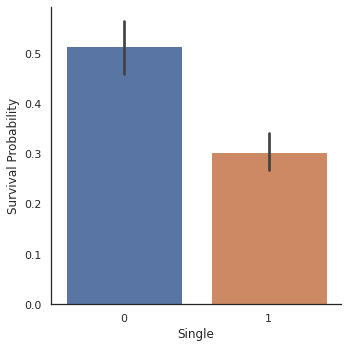

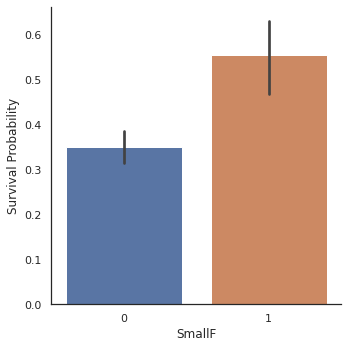

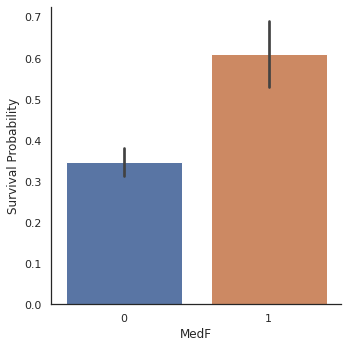

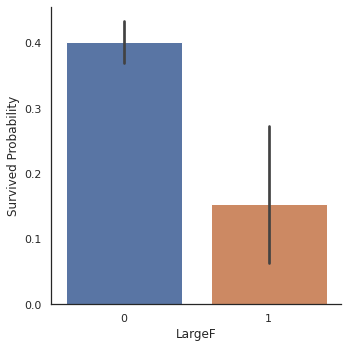

In [307]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survived Probability')

- 작은 가족과 중간 가족이 단독 승객 및 대가족보다 생존 확률이 더 높은 것으로 나타납니다.

In [308]:
#get_dummies() 함수를 사용하여 데이터셋에서 Title 및 Embarked 열을 원-핫 인코딩된 이진 벡터 열로 변환
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [309]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [310]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [311]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [312]:
dataset['Cabin'].isnull().sum()

1007

In [313]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [314]:
#null이 아니면 해당 값의 첫 번째 알파벳/ null 값이면 'X'로 대체
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

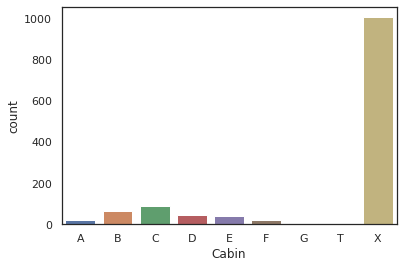

In [315]:
g = sns.countplot(x=pd.Series(dataset["Cabin"]), order=['A','B','C','D','E','F','G','T','X'])

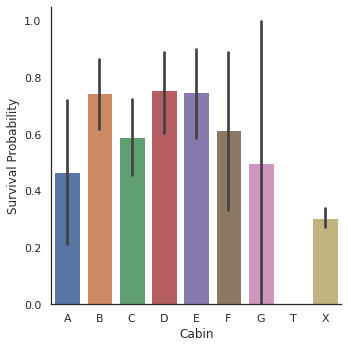

In [316]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset, kind='bar',order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

- 객실이 있는 승객 수가 적어 생존 확률에는 큰 표준 편차가 있으며 각각의 좌석에서 생존 확률을 구별할 수 없습니다.

- 하지만 객실이 있는 승객은 (X)가 없는 승객보다 생존 확률이 더 높은 것으로 보입니다.

- 특히 B, C, D, E, F 객실에서 그렇습니다.

In [317]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix='Cabin')

### 5.4 Ticket

In [318]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 같은 접두사를 공유하는 티켓은 함께 배치된 객실에 예약될 수 있습니다. 이로 인해 객실이 배치된 실제 위치를 결정할 수 있습니다.

- 같은 접두사를 가진 티켓은 유사한 등급과 생존 확률을 가질 수 있습니다.

- 그래서 저는 Ticket 기능 열을 티켓 접두사로 교체하기로 결정했습니다. 이것이 더 유익할 수 있습니다.

In [319]:
#Ticket 열에서 티켓 접두사만 추출하여 새로운 열로 추가
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit(): #숫자가 아니면 티켓 접두사를 추출하여 Ticket 리스트에 추가
    #문자열에서 마침표와 슬래시를 제거, 공백 제거, 첫번째 단어 선택택
    Ticket.append(i.replace(".","").replace("/", "").strip().split(' ')[0]) 
  else:
    Ticket.append('X')
  
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [320]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')

In [321]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix="Pc")

In [322]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [323]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6.Modeling

In [324]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

- axis: 0 또는 1 값을 지정하여 행(axis=0) 또는 열(axis=1)을 제거하는 방향을 선택하는 매개변수

- inplace: 기본값은 False이며, True로 설정하면 원본 데이터프레임에서 직접 제거를 수행합니다. 기본값이 False인 경우, 제거된 결과를 반환하지만 원본 데이터프레임은 변경되지 않습니다.

In [325]:
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis=1)

### 6.1 Simple modelling

### 6.1.1 Cross vaildate

- 서포트 벡터 머신(Support Vector Machine, SVM)

- 결정 트리(Decision Tree)

- 에이다부스트(AdaBoost)

- 랜덤 포레스트(Random Forest)

- 엑스트라 트리(Extra Trees)

- 그래디언트 부스팅(Gradient Boosting)

- 다중 레이어 퍼셉트론(신경망, Multiple Layer Perceptron)

- K 최근접 이웃(K-Nearest Neighbors, KNN)

- 로지스틱 회귀(Logistic Regression)

- 선형 판별 분석(Linear Discriminant Analysis)

In [326]:
kfold = StratifiedKFold(n_splits=10)

Text(0.5, 1.0, 'Cross validation scores')

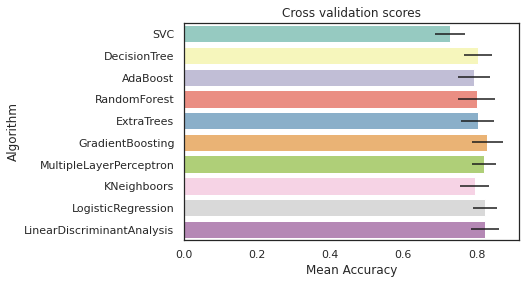

In [327]:
#다양한 머신러닝 모델을 사용하여 교차 검증을 수행
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

#교차 검증 결과를 cv_results 리스트에 저장
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

#데이터프레임으로 만들어 시각화
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x='CrossValMeans', y='Algorithm', data=cv_res, palette='Set3', orient='h', xerr=cv_std)
g.set_xlabel('Mean Accuracy')
g.set_title('Cross validation scores')

- 앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees 및 GradientBoosting 분류기를 선택했습니다.


### 6.1.2 Hyperparameter tunning for best models

- 각 모델마다 그리드 서치 최적화를 수행했습니다. 저는 4개의 CPU가 있기 때문에 "n_jobs" 매개변수를 4로 설정했고, 이로 인해 계산 시간이 크게 감소되었습니다.

- 하지만 이 단계는 매우 긴 시간이 소요될 수 있으므로 주의가 필요합니다. 저는 4개의 CPU에서 총 15분이 걸렸습니다.

In [328]:
#Decision Tree Classifier를 기본 모델로 AdaBoost Classifier의 하이퍼파라미터를 Grid Search를 통해 튜닝
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

#ada_param_grid에 하이퍼파라미터 후보군들을 딕셔너리 형태로 지정
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"], #결정 트리 분류 기준준
              "base_estimator__splitter" :   ["best", "random"], #노드 분할 기준준
              "algorithm" : ["SAMME","SAMME.R"], #알고리즘 종류류
              "n_estimators" :[1,2], #분류기 개수수
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]} #분류기 가중치 갱신 정도도

#adaDTC를 기본 모델로 사용하고, ada_param_grid를 하이퍼파라미터 후보군으로 설정
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

#최적모델 찾기
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [329]:
gsadaDTC.best_score_

0.8275536261491316

In [330]:
#ExtraTreesClassifier 모델을 생성
ExtC = ExtraTreesClassifier()

#ExtraTreesClassifier 모델의 hyperparameter를 설정
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

#ExtraTreesClassifier 모델의 최적의 hyperparameter
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

#최적의 hyperparameter로 학습된 ExtraTreesClassifier 모델 찾기
ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297497446373852

In [331]:
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth': [None],
                 'max_features': [1,3,10],
                 'min_samples_split': [2,3,10],
                 'min_samples_leaf':[1,3,10],
                 'bootstrap':[False],
                 'n_estimators':[100,300],
                 'criterion': ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308861082737486

In [334]:
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss': ['deviance'],
                 'n_estimators': [100,200,300],
                 'learning_rate' : [0.1,0.05, 0.01],
                 'max_depth': [4,8],
                 'min_samples_leaf': [100,150],
                 'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8297497446373852

In [335]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                  'gamma':[0.001,0.01,0.1,1],
                  'C': [1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid= svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### 6.1.3 Plot learning curves

학습 곡선은 훈련 세트에서의 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인하는 데 좋은 방법입니다.

In [337]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1,
                        train_sizes=np.linspace(.1,1.0,5)):
  """ 테스트 및 훈련 학습 곡선의 간단한 그래프 생성 함수
      estimator: 학습할 모델
      title: 그래프 제목
      X: 독립 변수 데이터
      y: 종속 변수 데이터
      ylim: y축 범위
      cv: cross-validation 객체
      n_jobs: 병렬 처리에 사용할 CPU 코어 수
      train_sizes: 학습 데이터 크기 비율
      """
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training examples')
  plt.ylabel('Score')

  #학습 곡선을 계산
  train_sizes, train_scores, test_scores = learning_curve(estimator,X, y, cv=cv, 
                                                          n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                   train_scores_mean + train_scores_std, alpha=0.1, color = 'r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color='g')
  
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
  plt.legend(loc='best')
  
  return plt
  

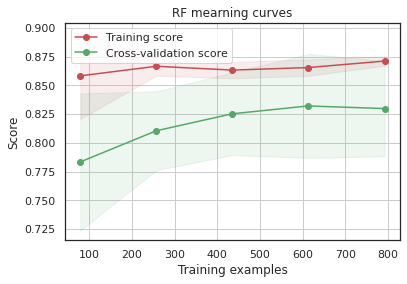

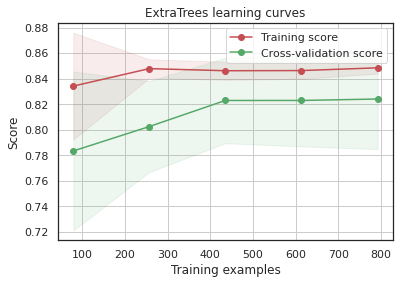

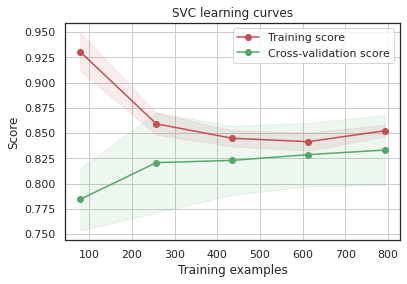

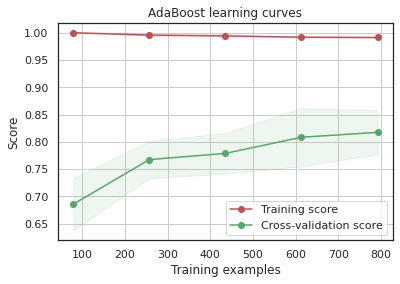

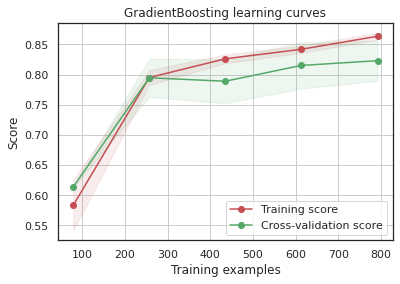

In [338]:
g = plot_learning_curve(gsRFC.best_estimator_, 'RF mearning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)

- GradientBoosting 및 Adaboost 분류기는 훈련 세트에 과적합되기 쉽습니다. 성장하는 교차 검증 곡선에 따르면, GradientBoosting 및 Adaboost는 더 많은 훈련 예제로 더 나은 성능을 발휘할 수 있습니다.

- SVC 및 ExtraTrees 분류기는 훈련 및 교차 검증 곡선이 서로 가까우므로 예측을 더 잘 일반화할 수 있습니다.

- 4개의 트리 기반 분류기의 특성 중요도를 표시하여 승객 생존 예측에 가장 유용한 특성을 확인할 수 있습니다.

### 6.1.4 Feature importance of tree based classifiers

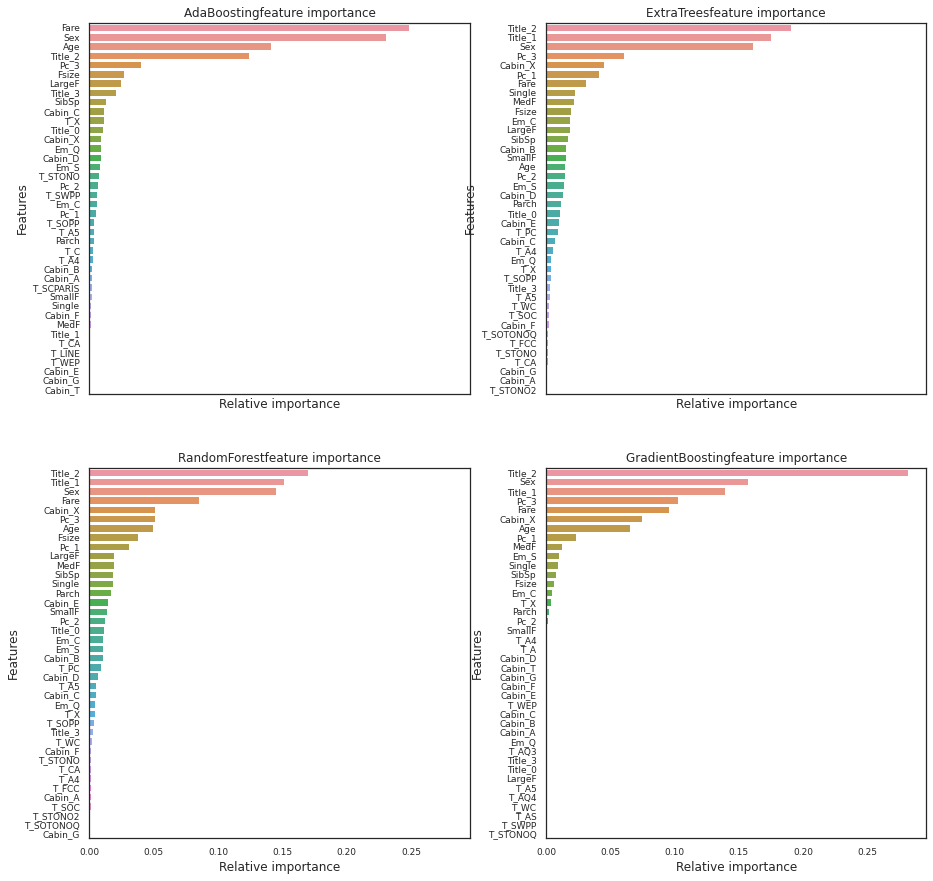

In [339]:
nrows = ncols = 2

# sharex='all': x축 눈금을 공유
fig, ax = plt.subplots(nrows,ncols,sharex='all', figsize=(15,15))

#names_classifiers 변수에 4개의 트리 기반 분류기 이름과 해당 분류기를 튜플 형태로 할당
names_classifiers =[('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), (
    'RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0

for row in range(nrows):
  for col in range(ncols):
    #names_classifiers에서 nclassifier번째 분류기의 이름을 name 변수에 할당
    name = names_classifiers[nclassifier][0]

    #names_classifiers에서 nclassifier 번째 분류기를 classifier 변수에 할당
    classifier = names_classifiers[nclassifier][1]

    #분류기에서 특성 중요도를 계산하고 상위 40개의 특성을 선택
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]

    # y에는 선택한 상위 40개 특성의 이름을 할당하고, x에는 해당 특성의 중요도 값을 할당
    g = sns.barplot(y=X_train.columns[indices][:40],
                    x=classifier.feature_importances_[indices][:40], orient='h', ax=ax[row][col])
   
    g.set_xlabel('Relative importance', fontsize=12)
    g.set_ylabel('Features', fontsize=12)
    g.tick_params(labelsize=9) #눈금 레이블 크기를 지정
    g.set_title(name+'feature importance')
    nclassifier += 1


- 4개의 트리 기반 분류기 (Adaboost, ExtraTrees, RandomForest 및 GradientBoosting)에 대한 특성 중요도를 시각화 했습니다.

- 상대적인 중요성에 따라 네 개의 분류기가 서로 다른 상위 특성을 가지고 있으므로 그들의 예측은 동일한 특성에 기반하지 않는다는 것을 알 수 있습니다. 그러나, 'Fare', 'Title_2', 'Age' 및 'Sex'와 같이 일부 공통적으로 중요한 특성을 공유합니다.

- Title_2는 Mrs/Mlle/Mme/Miss/Ms 범주를 나타내며, Sex와 강한 상관 관계가 있습니다.

- 우리는 다음과 같이 말할 수 있습니다:

    - Pc_1, Pc_2, Pc_3 및 Fare는 승객의 일반적인 사회적 지위를 나타냅니다.

    - Sex 및 Title_2 (Mrs/Mlle/Mme/Miss/Ms) 및 Title_3 (Mr)는 성별을 나타냅니다.

    - Age 및 Title_1 (Master)는 승객의 연령을 나타냅니다.

    - Fsize, LargeF, MedF, Single은 승객 가족의 크기를 나타냅니다.

- 이 4개 분류기의 특성 중요도에 따르면, 생존 예측은 배 내 위치보다는 승객의 연령, 성별, 가족 규모 및 사회적 지위와 더 관련이 있는 것으로 보입니다.

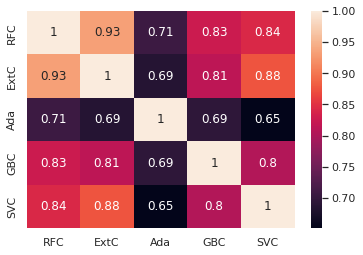

In [340]:
#test 데이터셋의 생존 여부를 예측하고, 그 결과를 pd.Series로 저장
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC,
                              test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC],axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

- 다섯 개의 분류기를 비교할 때, Adaboost와 다른 분류기들 간에 예측이 꽤 유사해 보입니다.

- 5개의 분류기는 거의 같은 예측을 제공하지만 약간의 차이가 있습니다. 이러한 5개 분류기 예측 간의 차이는 앙상블 투표를 고려할 만하다는 것을 의미합니다.

### 6.2 앙상블 모델링


### 6.2.1 모델 결합

- 5개 분류기에서 나오는 예측을 결합하기 위해 voying classifier를 선택했습니다.

- 각 투표의 확률을 고려하기 위해 voting 매개 변수에 "soft" 인자를 전달하는 것이 좋습니다.

In [342]:
# 5개의 다른 모델의 예측 결과를 결합, 다수결 투표 방식
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction

### 6.3.1 Predict and Submit results

In [344]:
#test_Survived 변수에 예측 값을 저장
test_Survived = pd.Series(votingC.predict(test), name='Survived')

#IDtest와 test_Survived 열을 연결하고 results라는 DataFrame에 저장
results = pd.concat([IDtest, test_Survived], axis=1)

# results DataFrame을 CSV 파일로 출력, index=False : 행 인덱스 포함 안함
results.to_csv('ensemble_python_voting.csv', index=False)